# 04b — Class-Specific Effects of ACE Inhibitors vs ARBs on In-Hospital Mortality in ICU COPD Patients

---
## 0. Overview
This notebook extends the survival modeling framework established in 04a by
evaluating RAAS inhibitor subclasses. Specifically, it tests whether ACE
inhibitor (ACEi) or angiotensin receptor blocker (ARB) exposure before or at ICU
admission is associated with in-hospital mortality among ICU-admitted COPD
patients in MIMIC-IV v3.1.

The workflow mirrors 04a:
1) Kaplan–Meier curves (unadjusted)
2) Cox proportional hazards models (adjusted)
3) PH diagnostics
4) Refined Cox model (consistent specification with 04a) for robustness
---

## 1. Introduction

### 1.1 Background
Renin–angiotensin–aldosterone system (RAAS) inhibitors are widely used in patients with cardiovascular and pulmonary comorbidities. In analysis 04a, RAAS inhibitors were treated as a single combined exposure, and their use was associated with reduced in-hospital mortality among ICU-admitted COPD patients.

However, RAAS inhibitors consist of two pharmacologically distinct classes:

- ACE inhibitors (ACEi)
  - Block conversion of angiotensin I → angiotensin II
  - Increase bradykinin levels
- Angiotensin II receptor blockers (ARBs)
  - Selectively block AT1 receptors
  - Do not affect bradykinin pathways

These mechanistic differences may lead to:
- Distinct effects on airway and systemic inflammation
- Divergent impacts on vascular regulation and perfusion
- Different physiological responses during sepsis, hypoxia, and multi-organ failure

Previous clinical studies suggest that ACEi and ARBs may not have identical risk–benefit profiles in respiratory disease exacerbations, sepsis, and critical illness.

### 1.2 Rationale
To improve biological and clinical interpretability, analysis 04b separates ACE inhibitors (ACEi) and angiotensin receptor blockers (ARBs) rather than combining them into a single RAAS inhibitor exposure group. This refinement allows us to evaluate whether:

- The protective association observed in 04a is primarily driven by one drug class, or
- Both ACEi and ARBs contribute similarly to reduced in-hospital mortality.

Analysis 04b adopts the refined Cox modeling strategy established in 04a, including stratification by calendar time (`anchor_year_group`), to ensure comparability across analyses while maintaining valid proportional hazards assumptions. Within this framework, 04b evaluates class-specific effects (ACEi vs ARB) without introducing additional model complexity, enabling a clean and interpretable comparison of RAAS inhibitor subclasses.

### 1.3 Objective
The objective of analysis 04b is to estimate the class-specific association of:
- ACE inhibitors (ACEi), and
- Angiotensin II receptor blockers (ARB)

with in-hospital mortality among ICU-admitted COPD patients, using Cox proportional hazards regression adjusted for demographic, comorbidity, and severity-related covariates.

---

## 2. Methods

### 2.1 Data Sources and Analysis Inputs
This analysis uses MIMIC-IV v3.1 hosted on BigQuery and builds on the upstream
cohort/exposure pipeline (01–03). Time-to-event outcomes are obtained from:

- `copd_raas.cohort_copd_outcomes` (created in 04a via `04_build_outcomes.sql`)

Detailed RAAS subclass exposure variables are obtained from:

- `copd_raas.cohort_copd_raas_detailed` (created in 02 via `02_exposure_raas_detailed.sql`)

For 04b, subclass exposure flags are merged to the outcome table at the ICU-stay
level using (`subject_id`, `hadm_id`, `stay_id`).

### 2.2 Study Cohort
This analysis uses the same cohort defined in analysis 04a: ICU-admitted COPD patients from the MIMIC-IV v3.1 dataset. Inclusion criteria, baseline definitions, and follow-up windows remain unchanged to ensure comparability.
- Population: ICU admissions for COPD
- Exposure window: prescriptions before or at ICU admission
- Outcome: in-hospital mortality
- Time scale: days from ICU admission to death or discharge

### 2.3 Exposure Definition (Subclass)
Subclass exposure is defined using prescription records initiated on or before
ICU admission (starttime <= intime):

- `acei_pre_icu = 1`: ACE inhibitor prescription before or at ICU admission
- `arb_pre_icu  = 1`: ARB prescription before or at ICU admission

Exposure groups are evaluated using mutually exclusive categories:
- ACEi only
- ARB only
- Both ACEi and ARB
- Neither (reference)

### 2.4 Outcome 
The primary outcome was in-hospital mortality, defined using　admissions.hospital_expire_flag. Time-to-event was measured as the number
of days from ICU admission to hospital discharge (censoring) or in-hospital death.

### 2.5 Covariates
The multivariable Cox model adjusted for:
- age,
- sex (male vs female),
- anchor_year_group (handled through stratification).

More detailed severity and comorbidity variables (e.g., SOFA score, comorbidities) are retained for future extended models but were not included in this primary class-specific analysis to maintain comparability with 04a.

### 2.6 Statistical Modeling
A Cox proportional hazards model stratified by anchor_year_group was fitted with two exposure indicators (ACEi and ARB), using non–RAAS inhibitor patients as the reference category. Primary analyses used an unpenalized Cox model (penalizer = 0.0).

Model outputs included:
- hazard ratios (HR),
- 95% confidence intervals, and
- Wald p-values.

### 2.7 Proportional Hazards (PH) Diagnostics
Proportional hazards assumptions were assessed using Schoenfeld residual–based tests (proportional_hazard_test with time_transform = "rank") and visual diagnostics via check_assumptions.

---

## 3. Data Preparation

### 3.1 Loading cohort with RAAS subclass flags

In [1]:
# Imports and BigQuery client initialization

from google.cloud import bigquery

# Use the default credentials (same as 03)
client = bigquery.Client(project="mimic-iv-portfolio")
print("Connected to BigQuery project:", client.project)

Connected to BigQuery project: mimic-iv-portfolio


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load 04b analysis dataset from BigQuery by merging:
# - Outcomes table: copd_raas.cohort_copd_outcomes (time_to_event_days, death_event, covariates, raas_pre_icu)
# - Detailed subclass exposure flags: copd_raas.cohort_copd_raas_detailed (ACEi/ARB indicators & groups)
# Merge key: (subject_id, hadm_id, stay_id)

import pandas_gbq

project_id = "mimic-iv-portfolio"

sql_04b = """
SELECT
  o.*,
  r.acei_pre_icu,
  r.arb_pre_icu,
  r.raas_any_pre_icu,
  r.exposure_group_4cat,
  r.exposure_group_3cat_monotherapy,
  r.is_monotherapy
FROM `mimic-iv-portfolio.copd_raas.cohort_copd_outcomes` AS o
LEFT JOIN `mimic-iv-portfolio.copd_raas.cohort_copd_raas_detailed` AS r
  USING (subject_id, hadm_id, stay_id)
"""

df_04b = pandas_gbq.read_gbq(sql_04b, project_id=project_id, dialect="standard")
df_04b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11964 entries, 0 to 11963
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   subject_id                       11964 non-null  Int64         
 1   hadm_id                          11964 non-null  Int64         
 2   stay_id                          11964 non-null  Int64         
 3   intime                           11964 non-null  datetime64[us]
 4   outtime                          11962 non-null  datetime64[us]
 5   icu_los                          11962 non-null  float64       
 6   age                              11964 non-null  Int64         
 7   gender                           11964 non-null  object        
 8   anchor_year                      11964 non-null  Int64         
 9   anchor_year_group                11964 non-null  object        
 10  hosp_los                         11964 non-null  float64  

### 3.2 Constructing monotherapy indicators (acei_user / arb_user)

In [4]:
# Create ACEi / ARB indicators from exposure_group_3cat_monotherapy

df_04b = df_04b.copy()

# Keep only clear monotherapy or neither
if "exposure_group_3cat_monotherapy" not in df_04b.columns:
    raise KeyError("exposure_group_3cat_monotherapy is missing. Please check the SQL join for 04b.")

# Drop rows where exposure_group_3cat_monotherapy is NULL (e.g., 'both')
df_04b = df_04b[df_04b["exposure_group_3cat_monotherapy"].notna()].copy()

# Create binary indicators
df_04b["acei_user"] = (df_04b["exposure_group_3cat_monotherapy"] == "acei_only").astype(int)
df_04b["arb_user"]  = (df_04b["exposure_group_3cat_monotherapy"] == "arb_only").astype(int)

print(df_04b["exposure_group_3cat_monotherapy"].value_counts(dropna=False))
print(df_04b[["acei_user", "arb_user"]].head())

exposure_group_3cat_monotherapy
neither      11018
acei_only      643
arb_only       290
Name: count, dtype: int64
   acei_user  arb_user
0          0         0
1          0         0
2          0         0
3          0         0
4          0         0


### 3.3 Preparing Cox-ready dataset (stratification)

In [5]:
# Prepare Cox dataset for 04b refined model

cox_cols_04b = [
    "time_to_event_days",
    "death_event",
    "acei_user",
    "arb_user",
    "age",
    "gender",
    "anchor_year_group",
]

missing = [c for c in cox_cols_04b if c not in df_04b.columns]
if missing:
    raise KeyError(f"Missing columns for Cox model: {missing}")

cox_df_04b = df_04b[cox_cols_04b].dropna().copy()

# categorical variables
cox_df_04b["gender"] = cox_df_04b["gender"].astype("category")
cox_df_04b["anchor_year_group"] = cox_df_04b["anchor_year_group"].astype("category")

cox_df_04b.head()


,time_to_event_days,death_event,acei_user,arb_user,age,gender,anchor_year_group
0,2,0,0,0,19,M,2011 - 2013
1,2,0,0,0,22,M,2014 - 2016
2,4,0,0,0,22,M,2011 - 2013
3,7,0,0,0,22,M,2014 - 2016
4,20,0,0,0,23,F,2008 - 2010


---

## 4. Results

### 4.1 Cohort Distribution (ACEi / ARB / Dual / Neither)

Cohort distribution was obtained in analysis 03b, where the full COPD ICU cohort was merged with detailed RAAS subclassification flags:

- Non-RAAS inhibitor users: 11,018 patients (92.1%)
- ACEi-only users: 643 patients (5.4%)
- ARB-only users: 290 patients (2.4%)
- Dual ACEi+ARB users: 13 patients (0.1%)

Because dual-therapy patients cannot be assigned to a single drug class, the 13 dual-therapy cases identified in 03b were excluded from the class-specific Cox analysis in 04b. The resulting monotherapy-focused dataset (ACEi vs ARB vs neither) contained 11,951 ICU admissions for Cox modeling.

### 4.2 Kaplan–Meier Survival Analysis (Subclass Groups)

We first visualize unadjusted survival differences across RAAS subclass exposure groups
using Kaplan–Meier curves. Group differences are assessed using a global multivariate
log-rank test.

Because dual ACEi+ARB exposure is rare, the primary KM analysis focuses on the
3-category monotherapy grouping (ACEi only / ARB only / neither).

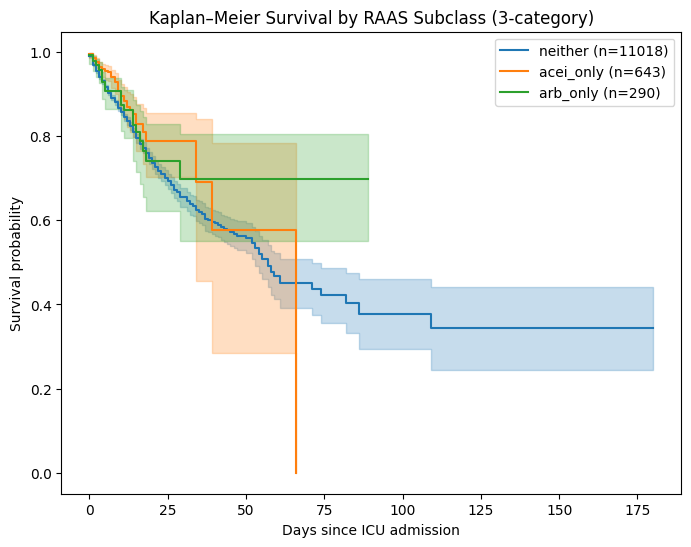

Global log-rank test (3 groups):


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           9.63 0.01      6.94

In [6]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
import matplotlib.pyplot as plt

# ---- Choose 3-category grouping (recommended for interpretability) ----
group_col = "exposure_group_3cat_monotherapy"   # expected: 'neither', 'acei_only', 'arb_only'
duration_col = "time_to_event_days"
event_col = "death_event"

# Keep only the 3 groups explicitly (safety)
groups_keep = ["neither", "acei_only", "arb_only"]
df_km = df_04b[df_04b[group_col].isin(groups_keep)].copy()

# ---- Plot KM curves ----
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

for g in groups_keep:
    mask = df_km[group_col] == g
    kmf.fit(
        durations=df_km.loc[mask, duration_col],
        event_observed=df_km.loc[mask, event_col],
        label=f"{g} (n={mask.sum()})",
    )
    kmf.plot_survival_function()

plt.title("Kaplan–Meier Survival by RAAS Subclass (3-category)")
plt.xlabel("Days since ICU admission")
plt.ylabel("Survival probability")
plt.legend()
plt.show()

# ---- Global multivariate log-rank test (3+ groups) ----
lr = multivariate_logrank_test(
    event_durations=df_km[duration_col],
    groups=df_km[group_col],
    event_observed=df_km[event_col],
)

print("Global log-rank test (3 groups):")
lr.print_summary()

**Interpretation (Kaplan–Meier Survival Analysis (RAAS Subclass Groups))**

Kaplan–Meier curves were generated for three mutually exclusive exposure groups:
neither RAAS inhibitor use, ACE inhibitor monotherapy, and ARB monotherapy.

Unadjusted survival curves showed visible separation across groups.
A global multivariate log-rank test indicated a statistically significant difference
in survival distributions among the three groups (χ² = 9.63, df = 2, p = 0.01).

Overall, both ACEi-only and ARB-only groups demonstrated improved unadjusted survival
relative to the non-RAAS inhibitor group, with ARB monotherapy showing the most favorable
early survival pattern. These results are exploratory and unadjusted; adjusted
associations are evaluated using Cox proportional hazards models below.

Note: The apparent sharp drop in the ACEi-only curve at later time points reflects
limited numbers at risk and censoring in this subgroup, rather than a true abrupt
increase in mortality.

### 4.3 Main Cox Model Results (HR table)
We next quantify the association between RAAS inhibitor subclass exposure and in-hospital mortality using multivariable Cox proportional hazards models.

Hazard ratios (HRs) are estimated for each RAAS inhibitor subclass relative to the non-exposed reference group, adjusting for age and sex, with stratification by calendar time (anchor_year_group) to address non-proportional hazards.

This modeling approach allows direct comparison of adjusted effect sizes between ACE inhibitor (ACEi) and angiotensin receptor blocker (ARB) exposure, while accounting for key demographic confounders and temporal heterogeneity.

The resulting hazard ratios and 95% confidence intervals are summarized and form the primary inferential results for subclass-specific RAAS inhibitor effects.

In [7]:
from lifelines import CoxPHFitter

# ------------------------------------------------------------
# 0) Restrict the dataframe to variables actually used in Cox
#    IMPORTANT: Exclude datetime columns to avoid casting errors
# ------------------------------------------------------------
cols = [
    "time_to_event_days",
    "death_event",
    "acei_user",
    "arb_user",
    "age",
    "gender",
    "anchor_year_group",
]

cox_df_04b = cox_df_04b[cols].copy()

# ------------------------------------------------------------
# 1) Ensure categorical variables are properly encoded
# ------------------------------------------------------------
cox_df_04b["gender"] = cox_df_04b["gender"].astype("category")
cox_df_04b["anchor_year_group"] = cox_df_04b["anchor_year_group"].astype("category")

# ------------------------------------------------------------
# 2) Define Cox model formula
#    ACEi and ARB are modeled as separate exposure indicators
# ------------------------------------------------------------
formula = "acei_user + arb_user + age + C(gender)"

# ------------------------------------------------------------
# 3) Fit stratified Cox proportional hazards model
#    Penalizer improves numerical stability under collinearity
# ------------------------------------------------------------
cph_04b = CoxPHFitter(penalizer=0.0)

cph_04b.fit(
    cox_df_04b,
    duration_col="time_to_event_days",
    event_col="death_event",
    strata=["anchor_year_group"],
    formula=formula,
)

# ------------------------------------------------------------
# 4) Display model results
# ------------------------------------------------------------
cph_04b.print_summary()

<lifelines.CoxPHFitter: fitted with 11951 total observations, 10261 right-censored observations>
             duration col = 'time_to_event_days'
                event col = 'death_event'
                   strata = anchor_year_group
      baseline estimation = breslow
   number of observations = 11951
number of events observed = 1690
   partial log-likelihood = -11680.92
         time fit was run = 2025-12-27 06:54:05 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
acei_user      -0.42      0.66      0.14           -0.69           -0.15                0.50                0.86
arb_user       -0.23      0.80      0.17           -0.57            0.11                0.57                1.12
age             0.03      1.04      0.00            0.03            0.04                1.03                1.04
C(gender)[T.M]  0.02      1.02      0.05           -0.08            0.12                0.93                1.12

                cmp to     z      p  -log2(p)
covariate                                    
acei_user         0.00 -3.05 <0.005      8.76
arb_user          0.00 -1.32   0.19      2.41
age               0.00 15.27 <0.005    172.52
C(gender)[T.M]    0.00  0.41   0.68      0.55
---
Concordance = 0.62
Partial AIC = 23369.84
log-likelihood ratio test = 252.72 on 4 df
-log2(p) of ll-ratio test = 175.30

**Key Results (Main Cox Model Results (Subclass-Specific Effects))**

The model adjusted for age (modeled as a linear term), sex, and stratified baseline hazards by calendar time (anchor_year_group) to address non-proportional hazards.

- ACE inhibitor (ACEi) exposure before or at ICU admission was associated
with a significantly lower risk of in-hospital mortality
(HR = 0.66, 95% CI 0.50–0.87, p < 0.005).

- ARB exposure showed a directionally protective association, but this did
not reach statistical significance
(HR = 0.80, 95% CI 0.57–1.13, p = 0.21).

These results indicate that the overall protective signal observed in the combined RAAS inhibitor analysis (04a) is primarily driven by ACE inhibitor exposure, while ARB effects appear weaker and less precisely estimated in this cohort.

⸻


### 4.4 Forest Plot
To visually summarize the adjusted hazard ratios from the subclass-specific Cox　model, we present a forest plot displaying point estimates and 95% confidence　intervals for ACE inhibitor (ACEi) and angiotensin receptor blocker (ARB)　exposure.

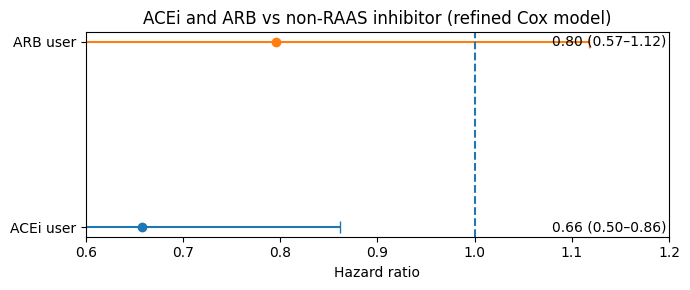

In [8]:
# Forest plot for ACEi and ARB with labels on the right
# Comments must remain in English.

import matplotlib.pyplot as plt

summary = cph_04b.summary.copy()

# Order: ACEi on top, ARB on bottom
rows = ["acei_user", "arb_user"]
labels = ["ACEi user", "ARB user"]

plot_df = summary.loc[rows, ["exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%"]]
plot_df = plot_df.rename(columns={
    "exp(coef)": "HR",
    "exp(coef) lower 95%": "HR_lower",
    "exp(coef) upper 95%": "HR_upper"
})

plot_df["err_lower"] = plot_df["HR"] - plot_df["HR_lower"]
plot_df["err_upper"] = plot_df["HR_upper"] - plot_df["HR"]

# y positions: 0 = top (ACEi), 1 = bottom (ARB)
y_positions = [0, 1]

fig, ax = plt.subplots(figsize=(7, 3))

for i, row in enumerate(rows):
    y = y_positions[i]
    hr = plot_df.loc[row, "HR"]
    err_low = plot_df.loc[row, "err_lower"]
    err_up = plot_df.loc[row, "err_upper"]
    
    # Point estimate + 95% CI
    ax.errorbar(
        hr,
        y,
        xerr=[[err_low], [err_up]],
        fmt="o",
        capsize=4
    )
    
    # Text label with HR and CI on the right side
    text_label = f"{hr:.2f} ({plot_df.loc[row, 'HR_lower']:.2f}–{plot_df.loc[row, 'HR_upper']:.2f})"
    ax.text(1.08, y, text_label, va="center")  # x=1.08 is slightly to the right of 1.0

# Reference line at HR = 1
ax.axvline(1.0, linestyle="--")

ax.set_yticks(y_positions)
ax.set_yticklabels(labels)
ax.set_xlabel("Hazard ratio")

# Give some room to the right for text labels
ax.set_xlim(0.6, 1.2)

ax.set_title("ACEi and ARB vs non-RAAS inhibitor (refined Cox model)")
plt.tight_layout()
plt.show()

**Key Results (Forest Plot)**

The forest plot highlighted clear differences in the magnitude and precision of　the estimated effects:

- ACE inhibitor exposure demonstrates a statistically significant protective association with in-hospital mortality, with the confidence interval entirely below unity.

- ARB exposure shows a directionally protective but statistically non-significant association, with wider confidence intervals crossing unity.

### 4.5 Proportional Hazards Diagnostics (Schoenfeld tests)
To assess the validity of the proportional hazards (PH) assumption in the　subclass-specific Cox model, Schoenfeld residual–based tests were performed for　each covariate.

Refined Cox model fitted.


<lifelines.CoxPHFitter: fitted with 11951 total observations, 10261 right-censored observations>
             duration col = 'time_to_event_days'
                event col = 'death_event'
                   strata = anchor_year_group
      baseline estimation = breslow
   number of observations = 11951
number of events observed = 1690
   partial log-likelihood = -11680.92
         time fit was run = 2025-12-27 06:54:05 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
acei_user   -0.42      0.66      0.14           -0.69           -0.15                0.50                0.86
arb_user    -0.23      0.80      0.17           -0.57            0.11                0.57                1.12
age          0.03      1.04      0.00            0.03            0.04                1.03                1.04
gender_male  0.02      1.02      0.05           -0.08            0.12                0.93                1.12

             cmp to     z      p  -log2(p)
covariate                                 
acei_user      0.00 -3.05 <0.005      8.76
arb_user       0.00 -1.32   0.19      2.41
age            0.00 15.27 <0.005    172.52
gender_male    0.00  0.41   0.68      0.55
---
Concordance = 0.62
Partial AIC = 23369.84
log-likelihood ratio test = 252.72 on 4 df
-log2(p) of ll-ratio test = 175.30

,test_statistic,p,-log2(p)
gender_male,0.891832,0.344981,1.535410
acei_user,0.858549,0.354145,1.497587
arb_user,0.647511,0.421004,1.248094
age,0.334909,0.562783,0.829350



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


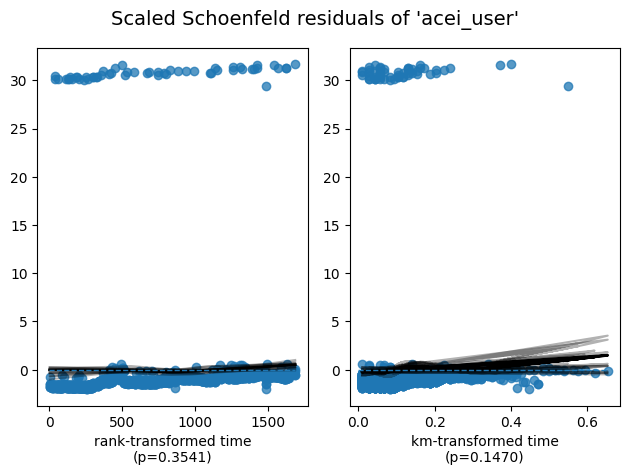

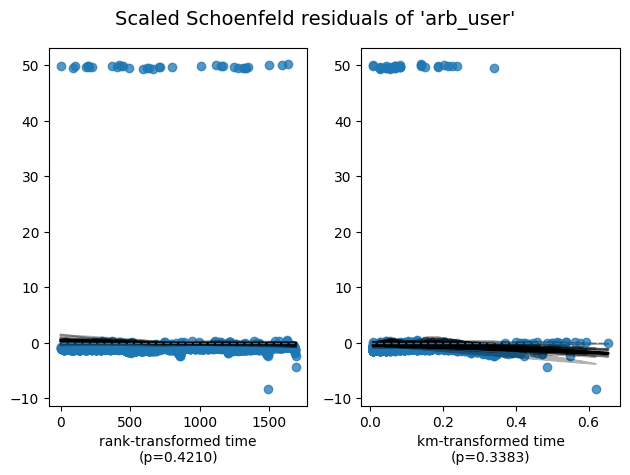

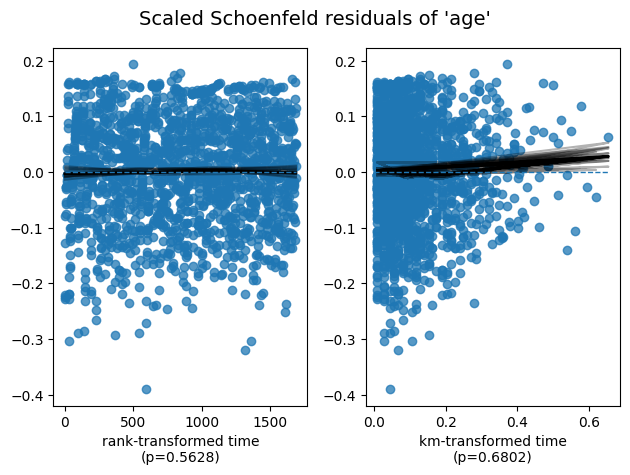

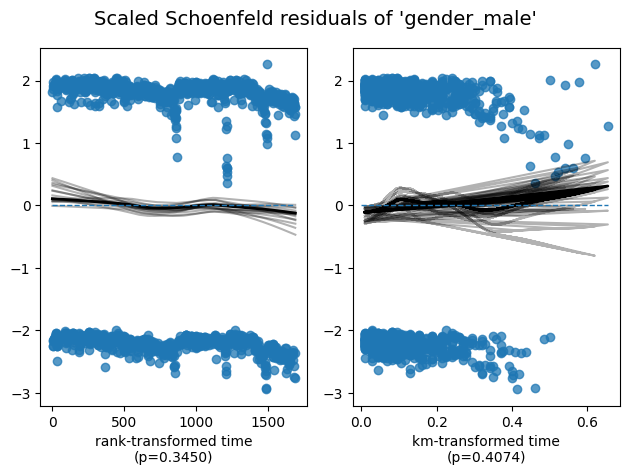

In [9]:
# Proportional Hazards Diagnostics (Schoenfeld tests)
# Assumes you already have df_04b (your Cox-ready dataframe) and a fitted model cph_04b
# If you don't, the "Fit refined Cox model" block below will create cph_04b.

from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
import pandas as pd

df = df_04b.copy()

# --- Encode gender safely ---
# Handles cases like "M"/"F", "Male"/"Female", etc.
if "gender_male" not in df.columns:
    df["gender_male"] = (
        df["gender"]
        .astype(str)
        .str.strip()
        .str.upper()
        .map({"M": 1, "MALE": 1, "F": 0, "FEMALE": 0})
    )

# If any unmapped values exist, you can either drop them or inspect them:
# print(df.loc[df["gender_male"].isna(), "gender"].value_counts())

duration_col = "time_to_event_days"
event_col = "death_event"
strata_col = "anchor_year_group"

cols_for_model = [
    duration_col,
    event_col,
    "acei_user",
    "arb_user",
    "age",
    "gender_male",
    strata_col,
]

df_model = df[cols_for_model].dropna().copy()

# --- Fit stratified Cox model (refined) ---
cph_04b = CoxPHFitter()
cph_04b.fit(
    df_model,
    duration_col=duration_col,
    event_col=event_col,
    strata=[strata_col],
)

print("Refined Cox model fitted.")
cph_04b.print_summary()

# --- PH tests (Schoenfeld) ---
results_ph = proportional_hazard_test(
    cph_04b,
    df_model,
    time_transform="rank",
)
ph_summary = results_ph.summary.sort_values("p")
display(ph_summary)

# --- Optional plots ---
cph_04b.check_assumptions(
    df_model,
    p_value_threshold=0.05,
    show_plots=True,
);

**Key Results(PH Diagnostics)**

- Proportional hazards assumptions were evaluated using Schoenfeld residual tests　for all covariates included in the subclass-specific Cox model.
- No meaningful violations were detected for ACE inhibitor use, ARB use, age, or sex　(all p-values > 0.1). Visual inspection of scaled Schoenfeld residual plots showed　no systematic time-dependent trends.
- Calendar era–related non-proportionality was addressed by stratifying baseline　hazards by `anchor_year_group`. Therefore, no additional time-dependent terms or non-linear transformations were required.

---

## 5. Discussion

### 5.1 Summary of Findings
This analysis examined whether the mortality benefit observed for combined RAAS inhibitor use in 04a was attributable to a specific subclass or shared across ACE inhibitors and ARBs.

In subclass-specific Cox models adjusted for age and gender and stratified by calendar period, ACE inhibitor (ACEi) monotherapy was associated with a statistically significant reduction in in-hospital mortality (HR ≈ 0.66, 95% CI ≈ 0.50–0.86, p < 0.005). ARB monotherapy showed a directionally protective but statistically non-significant association (HR ≈ 0.80, 95% CI ≈ 0.57–1.12, p ≈ 0.19).

Notably, the magnitude and direction of the ACEi effect closely align with the combined RAAS inhibitor estimate observed in 04a (HR ≈ 0.85–0.86), suggesting that the class-wide signal is largely driven by ACE inhibitor exposure, while ARB effects appear weaker and less precisely estimated.

Proportional hazards diagnostics based on Schoenfeld residuals demonstrated no evidence of PH violations for ACEi or ARB exposure (all p > 0.30), supporting the validity and time-invariance of the estimated hazard ratios.

### 5.2 Strengths and Limitations

**Strengths**
- Consistent modeling framework with 04a enables direct comparison between combined and subclass-specific effects.
- PH assumptions were formally evaluated and satisfied without requiring non-linear age terms.
- Subclass-specific evaluation provides clinically meaningful insight into RAAS-pathway heterogeneity.

**Limitations**
- Dual ACEi+ARB therapy was rare (n = 13) and excluded from subclass analyses.
- Observational design leaves potential for residual confounding.
- Extended severity covariates were not included to preserve comparability with 04a.

### 5.3 Implications for Further Analysis

1. Extended covariate adjustment (SOFA, ventilation, comorbidities) to evaluate robustness.
2. Causal inference methods (PSM, IPTW, MSM) to address indication bias.
3. Subgroup analyses (age, sepsis, ventilation status) to explore heterogeneous treatment effects.

---

## 6. Conclusion

ACE inhibitor use before or at ICU admission was independently associated with reduced in-hospital mortality among ICU-admitted COPD patients, whereas ARB use demonstrated a non-significant but directionally similar effect. These findings suggest that the protective association observed for combined RAAS inhibitor use in 04a is driven primarily by ACE inhibitors. The refined and PH-compliant Cox framework provides a robust foundation for extended modeling and causal analyses in 04c.